In [72]:
# Importing libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.plots import plot_convergence




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None


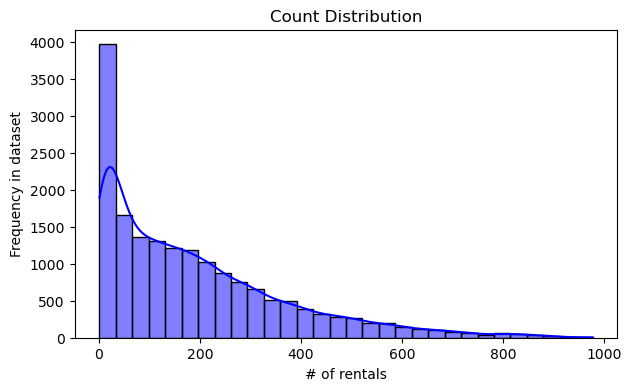

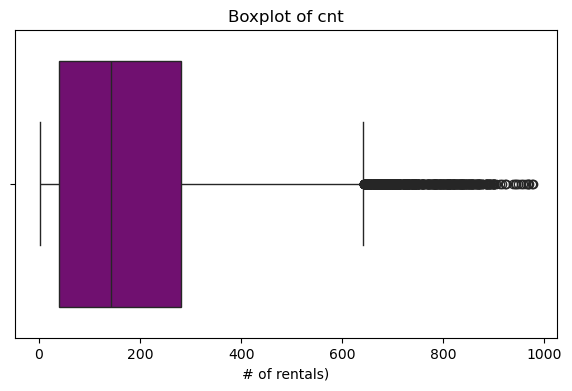

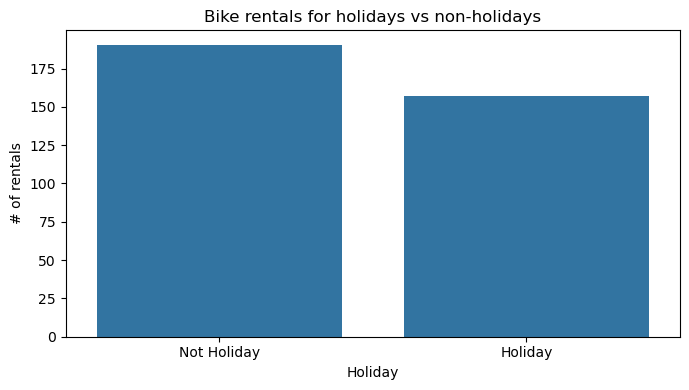

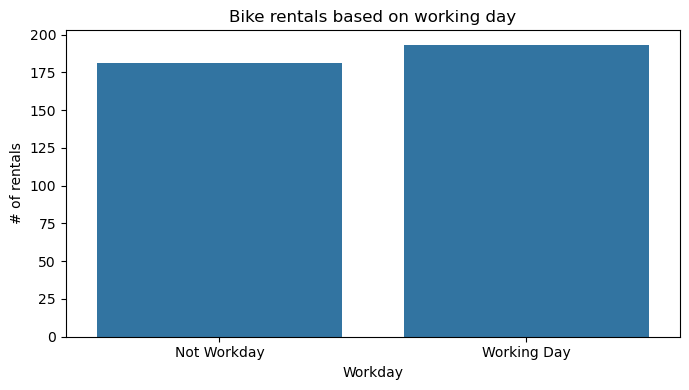


Rentals based on weekday:
Weekday with the most rentals: Friday 487790
Weekday with the least rentals: Sunday 444027

Rentals based on weather situation:
weathersit
1    2338173
2     795952
3     158331
4        223
Name: cnt, dtype: int64
           temp     atemp
temp   1.000000  0.987672
atemp  0.987672  1.000000
          temp       hum
temp  1.000000 -0.069881
hum  -0.069881  1.000000


In [73]:
# Task 1: Exploratory Data Analysis

# loading data into DataFrame
df = pd.read_csv("/Users/clairestewart/ML-fundamentals-2025/bike+sharing+dataset/hour.csv")
df.head()
print(df.info())


# cnt distribution
plt.figure(figsize=(7, 4))
sns.histplot(df['cnt'], kde=True, bins=30, color='blue')
plt.title('Count Distribution', fontsize=12)
plt.xlabel('# of rentals', fontsize=10)
plt.ylabel('Frequency in dataset', fontsize=10)
plt.show()

# boxplot to see cnt skew
plt.figure(figsize=(7, 4))
sns.boxplot(x=df['cnt'], color='purple')
plt.title('Boxplot of cnt', fontsize=12)
plt.xlabel('# of rentals)', fontsize=10)
plt.show()


# rentals based on holiday 
holiday_avg = df.groupby('holiday')['cnt'].mean().reset_index()
plt.figure(figsize=(7, 4))
sns.barplot(data=holiday_avg, x='holiday', y='cnt')
plt.xticks([0, 1], ['Not Holiday', 'Holiday'])
plt.title('Bike rentals for holidays vs non-holidays')
plt.xlabel('Holiday')
plt.ylabel('# of rentals')
plt.tight_layout()
plt.show()

# rentals based on workday 
workday_avg = df.groupby('workingday')['cnt'].mean().reset_index()
plt.figure(figsize=(7, 4))
sns.barplot(data=workday_avg, x='workingday', y='cnt')
plt.xticks([0, 1], ['Not Workday', 'Working Day'])
plt.title('Bike rentals based on working day')
plt.xlabel('Workday')
plt.ylabel('# of rentals')
plt.tight_layout()
plt.show()

# rentals based on weekday 
days = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
rentals_by_day = df.groupby('weekday')['cnt'].sum()
print("\nRentals based on weekday:")
print('Weekday with the most rentals:', days[rentals_by_day.idxmax()], rentals_by_day.max())
print('Weekday with the least rentals:', days[rentals_by_day.idxmin()], rentals_by_day.min())

# rentals based on weather
# maybe try to print names with the sums
weather = {1: 'Clear, Few clouds, Partly cloudy', 2: 'Mist + cloudy', 3: 'Light snow/rain', 
           4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'}
print("\nRentals based on weather situation:")
print(df.groupby('weathersit')['cnt'].sum())

# Checking temp x atemp correlation
print(df[['temp', 'atemp']].corr())
df.drop(columns=['atemp'], inplace=True)

# Checking temp x hum correlation
print(df[['temp', 'hum']].corr())

# Dropping values 
df.drop(columns=['instant', 'casual', 'registered', 'dteday'], inplace=True)



In [74]:
# Task 2: Data Splitting

# come back and sort bins to preserve temporal order?

x = df.drop(columns=['cnt'])
y = df['cnt']

# First split: split into training data and others
x_train, x_other, y_train, y_other = train_test_split(x, y, test_size=0.4, random_state=42, stratify=x['yr'])

# Second split: split the others into test and validation sets
x_val, x_test, y_val, y_test = train_test_split(x_other, y_other, test_size=0.5, random_state=42)

# Print sizes of each set to confirm
print("training set:", x_train.shape)
print("validation set:", x_val.shape)
print("test set:", x_test.shape)


training set: (10427, 11)
validation set: (3476, 11)
test set: (3476, 11)


Analysis:

didn't sort bins at first but was creating different columns during one-hot encoding


In [76]:
# Task 3: Feature Engineering 

# Encoding hr and weekday for training sest
x_train['hr_sin'] = np.sin(2 * np.pi * df['hr']/24.0)
x_train['hr_cos'] = np.cos(2 * np.pi * df['hr']/24.0)

x_train['weekday_sin'] = np.sin(2 * np.pi * df['weekday']/7.0)
x_train['weekday_cos'] = np.cos(2 * np.pi * df['weekday']/7.0)

# Encoding hr and weekday for val and test sets
x_val['hr_sin'] = np.sin(2 * np.pi * df['hr']/24.0)
x_val['hr_cos'] = np.cos(2 * np.pi * df['hr']/24.0)

x_val['weekday_sin'] = np.sin(2 * np.pi * df['weekday']/7.0)
x_val['weekday_cos'] = np.cos(2 * np.pi * df['weekday']/7.0)

x_test['hr_sin'] = np.sin(2 * np.pi * df['hr']/24.0)
x_test['hr_cos'] = np.cos(2 * np.pi * df['hr']/24.0)

x_test['weekday_sin'] = np.sin(2 * np.pi * df['weekday']/7.0)
x_test['weekday_cos'] = np.cos(2 * np.pi * df['weekday']/7.0)

x_train.drop(columns=['hr', 'weekday'], inplace=True)
x_val.drop(columns=['hr', 'weekday'], inplace=True)
x_test.drop(columns=['hr', 'weekday'], inplace=True)


# One hot encoding on season, weathersit, yr, and mnth for training set
encode_cols = ['season', 'weathersit', 'yr','mnth']
x_train = pd.get_dummies(x_train, columns=encode_cols)

# One hot encoding validation and test sets
x_val = pd.get_dummies(x_val, columns=encode_cols)
x_test = pd.get_dummies(x_test, columns=encode_cols)

# Applying Scaler to training set 
scale_cols = ['temp', 'hum', 'windspeed']
scaler = StandardScaler()
x_train[scale_cols] = scaler.fit_transform(x_train[scale_cols])

# Applying scaler to validation and test sets 
x_val[scale_cols] = scaler.transform(x_val[scale_cols])
x_test[scale_cols] = scaler.transform(x_test[scale_cols])




Mean Squared Error: 16691.881670742234
Mean Absolute Error: 93.07623705408515
R2 Score 0.5174668685413637


Text(0, 0.5, 'Residuals')

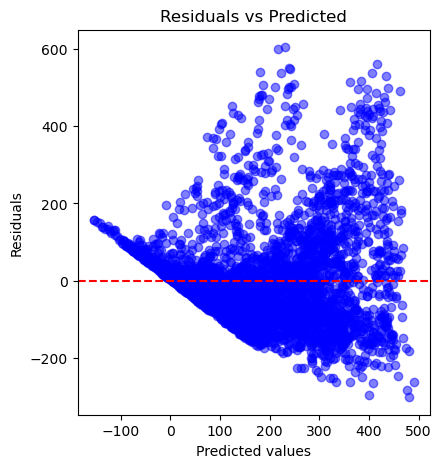

In [77]:
# Task 4: Baseline Model - Linear Regression

baseline_model = LinearRegression()
baseline_model.fit(x_train, y_train)

# predict model with validation set
y_pred_baseline = baseline_model.predict(x_val)

# Evaluating Model 
baseline_mse = mean_squared_error(y_val, y_pred_baseline) 
baseline_mae = mean_absolute_error(y_val, y_pred_baseline) 
baseline_r2 = r2_score(y_val, y_pred_baseline)

print("Mean Squared Error:", baseline_mse)
print("Mean Absolute Error:", baseline_mae)
print("R2 Score", baseline_r2)

residuals = y_val - y_pred_baseline
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_baseline, residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Horizontal line at 0
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')



Analysis:

Pattern - funnel shape 

Mean Squared Error: 1830.677827042578
Mean Absolute Error: 26.397957422324506
R2 Score 0.9470783029738872


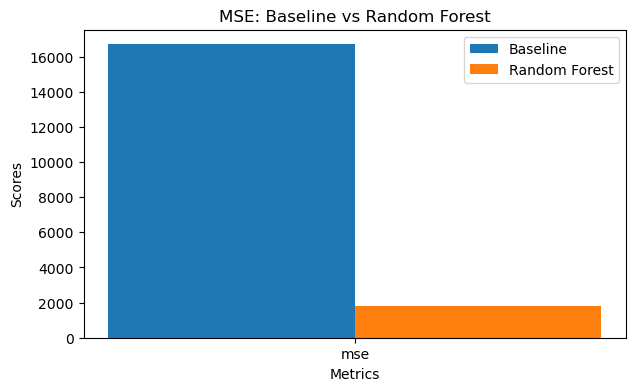

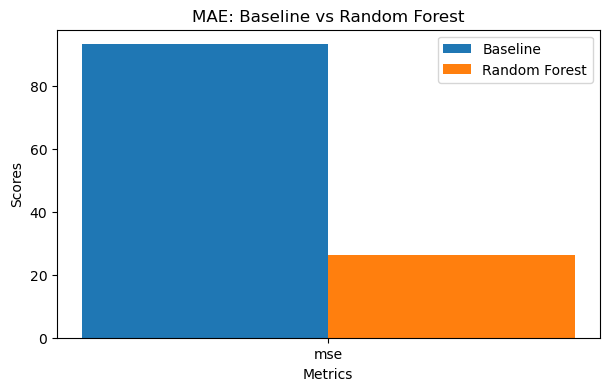

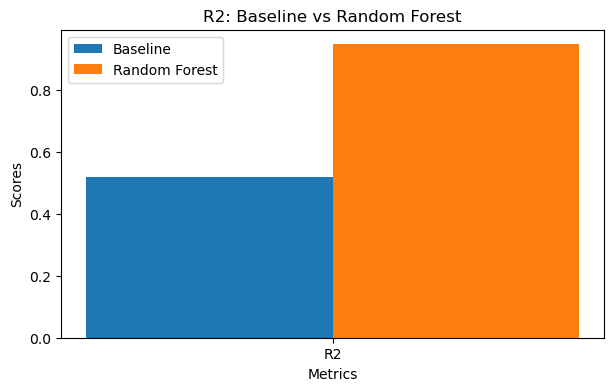

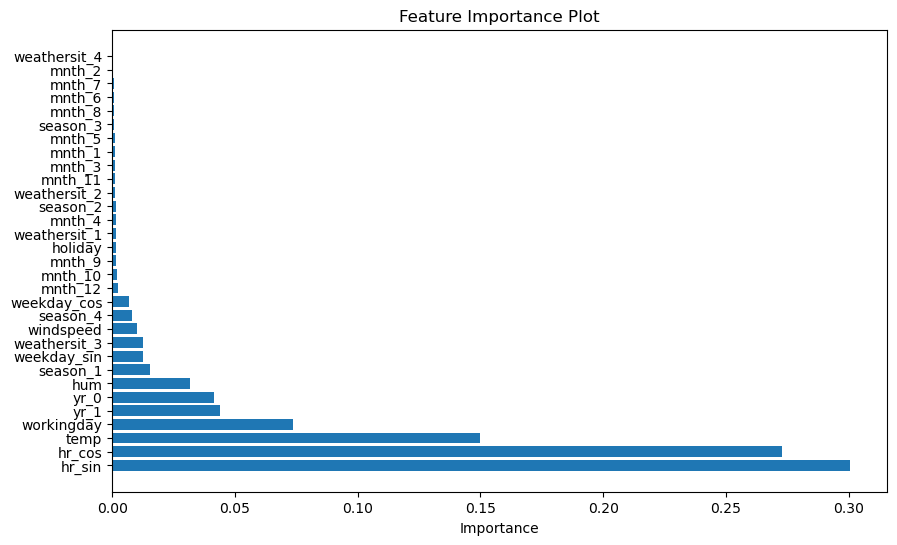

In [79]:
# Task 5: Random Forest Regressor - Model Specification and Training

rf = RandomForestRegressor()
rf.fit(x_train, y_train)

y_pred_rf = rf.predict(x_val)

# Evaluating Model 
rf_mse = mean_squared_error(y_val, y_pred_rf) 
rf_mae = mean_absolute_error(y_val, y_pred_rf) 
rf_r2 = r2_score(y_val, y_pred_rf)

print("Mean Squared Error:", rf_mse)
print("Mean Absolute Error:", rf_mae)
print("R2 Score", rf_r2)


# MSE comparison
mse = ['mse']
x = np.arange(1) 
width = 0.1  
fig, ax = plt.subplots(figsize=(7, 4))
rects1 = ax.bar(x - width/2, baseline_mse, width, label='Baseline')
rects2 = ax.bar(x + width/2, rf_mse, width, label='Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(mse)
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('MSE: Baseline vs Random Forest')
ax.legend()
plt.show()

# MAE Comparison
mae = ['MAE']
x = np.arange(1) 
width = 0.1
fig, ax = plt.subplots(figsize=(7, 4))
rects1 = ax.bar(x - width/2, baseline_mae, width, label='Baseline')
rects2 = ax.bar(x + width/2, rf_mae, width, label='Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(mse)
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('MAE: Baseline vs Random Forest')
ax.legend()
plt.show()

# R2 comparison
mse = ['R2']
x = np.arange(1) 
width = 0.1  
fig, ax = plt.subplots(figsize=(7, 4))
rects1 = ax.bar(x - width/2, baseline_r2, width, label='Baseline')
rects2 = ax.bar(x + width/2, rf_r2, width, label='Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(mse)
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('R2: Baseline vs Random Forest')
ax.legend()
plt.show()

# Feature importance plot
import_features = rf.feature_importances_
feature_names = x_train.columns
indices = np.argsort(import_features)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Feature Importance Plot')
plt.barh(range(len(indices)), import_features[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.show()




Mean Squared Error: 4643.017133221119
Mean Absolute Error: 47.418946149578964
R2 Score 0.9470783029738872


Text(0, 0.5, 'Residuals')

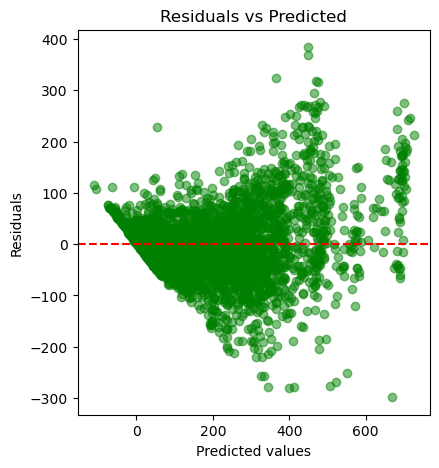

In [80]:
# Task 6: Gradient Boosting Regressor - Model Specification and Training

gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)

y_pred_gbr = gbr.predict(x_val)

# Evaluating Model 
gbr_mse = mean_squared_error(y_val, y_pred_gbr) 
gbr_mae = mean_absolute_error(y_val, y_pred_gbr) 
gbr_r2 = r2_score(y_val, y_pred_rf)

print("Mean Squared Error:", gbr_mse)
print("Mean Absolute Error:", gbr_mae)
print("R2 Score", gbr_r2)

# Plot residuals 
gbr_residuals = y_val - y_pred_gbr
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_gbr, gbr_residuals, color='green', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mean Squared Error: 1785.4281027001905
Mean Absolute Error: 26.25324145994443
R2 Score 0.9483863934345836


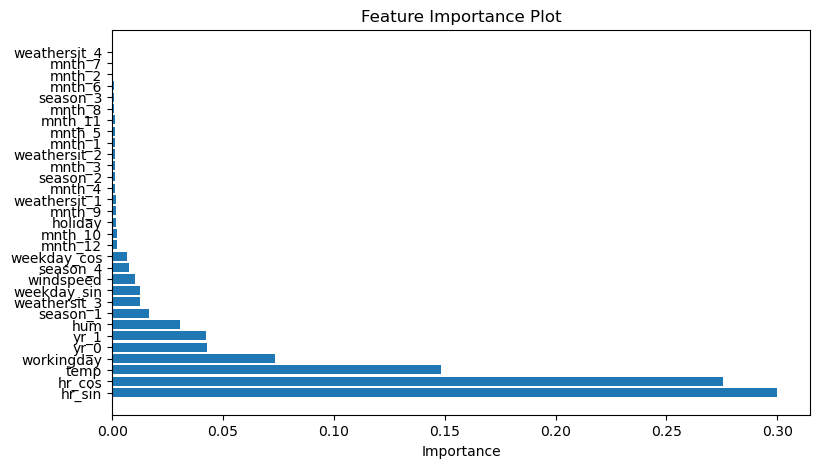


Best Random Forest (Randomized Search) Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20} 


In [81]:
# Task 7: Hyperparameter Tuning - Part 1

# Tune Random Forest Regressor 

# Define hyperparameter grid
rf_param_grid = {
"n_estimators": [50, 100, 200],
"max_depth": [None, 10, 20, 30],
"min_samples_split": [2, 5, 10],
"min_samples_leaf": [1, 2, 4],
}

# define random search
rf_random_search = RandomizedSearchCV(
estimator=rf,
param_distributions=rf_param_grid,
n_iter=50,
scoring="r2",
cv=5,
n_jobs=-1,
verbose=1,
random_state=42,
)


rf_random_search.fit(x_train, y_train)
y_pred_rf_random = rf_random_search.predict(x_val)

# Evaluation
rs_mse = mean_squared_error(y_val, y_pred_rf_random) 
rs_mae = mean_absolute_error(y_val, y_pred_rf_random) 
rs_r2 = r2_score(y_val, y_pred_rf_random)

print("Mean Squared Error:", rs_mse)
print("Mean Absolute Error:", rs_mae)
print("R2 Score", rs_r2)

# Feature importance plot
best_rs_model = rf_random_search.best_estimator_
importances = best_rs_model.feature_importances_

# Feature importance plot
rs_features = best_rs_model.feature_importances_
rs_feature_names = x_train.columns
indices = np.argsort(rs_features)[::-1]
plt.figure(figsize=(9, 5))
plt.title('Feature Importance Plot')
plt.barh(range(len(indices)), rs_features[indices], align='center')
plt.yticks(range(len(indices)), [rs_feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.show()

# Printing best hyperparameters 
print("\nBest Random Forest (Randomized Search) Parameters: %s "
% rf_random_search.best_params_
)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

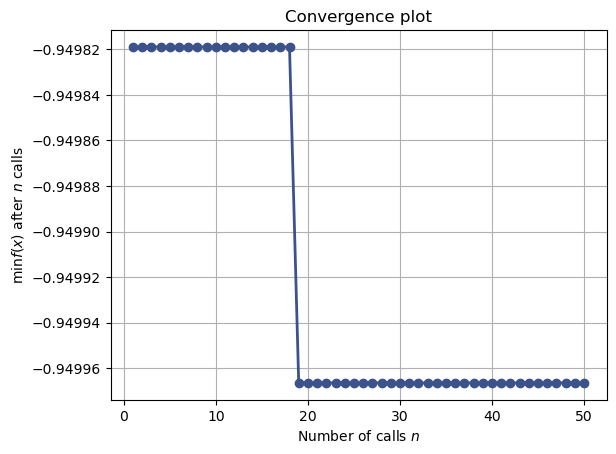

Mean Squared Error: 1446.429582532259
Mean Absolute Error: 23.1049553397017
R2 Score 0.9581862482815777

Best Gradient Boosting (Bayesian Optimization) Parameters: OrderedDict({'learning_rate': 0.03416946276340872, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.5})


In [82]:
# Task 7: Hyperparameter Tuning - Part 2

# Tune Gradient Boosting Regressor

# Define hyperparameter search space
gbr_param_space = {
"n_estimators": (50, 300), 
"learning_rate": (0.01, 1.0, "log-uniform"),
"max_depth": (3, 10), 
"subsample": (0.5, 1.0, "uniform"),
}

bayes_search = BayesSearchCV(
    estimator=gbr,
    search_spaces=gbr_param_space,
    n_iter=50, 
    scoring="r2",
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

# Fit the Bayesian optimization search on the training data.
bayes_search.fit(x_train, y_train)

# Make predictions on the validation set.
bs_y_pred = bayes_search.predict(x_val)

# Visualizing convergence
plot_convergence(bayes_search.optimizer_results_[0]) 
plt.show()

# Evaluation
bs_mse = mean_squared_error(y_val, bs_y_pred) 
bs_mae = mean_absolute_error(y_val, bs_y_pred) 
bs_r2 = r2_score(y_val, bs_y_pred)

print("Mean Squared Error:", bs_mse)
print("Mean Absolute Error:", bs_mae)
print("R2 Score", bs_r2)

# Printing best hyperparameters
print(
"\nBest Gradient Boosting (Bayesian Optimization) Parameters: %s"
% bayes_search.best_params_
)

In [83]:
# Task 8: Iterative Evaluation and Refinement



#### Task 8: Analysis and Documentation

In [85]:
# Task 9: Final Model Selection and Testing